In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from riskcurve.pipeline import run_pipeline_d1
from riskcurve.core import viz

In [21]:
raw = pd.read_csv('./EURUSD_20015-2025_daily.csv')

In [22]:
raw.columns = raw.columns.str.lower()

In [23]:
raw.head()

,date,timestamp,open,high,low,close,volume
0,20150101,00:00:00,1.21038,1.21073,1.20783,1.20869,5732.389980
1,20150102,00:00:00,1.20871,1.20890,1.20004,1.20017,119383.709762
2,20150104,00:00:00,1.19495,1.19537,1.18677,1.19469,13740.640014
3,20150105,00:00:00,1.19469,1.19762,1.18872,1.19374,159296.569873
4,20150106,00:00:00,1.19374,1.19687,1.18461,1.18722,177669.789751


In [24]:
raw.isnull().mean()

date         0.0
timestamp    0.0
open         0.0
high         0.0
low          0.0
close        0.0
volume       0.0
dtype: float64

In [25]:
raw.drop(['timestamp'], axis=1, inplace=True)

In [26]:
raw.head()

,date,open,high,low,close,volume
0,20150101,1.21038,1.21073,1.20783,1.20869,5732.389980
1,20150102,1.20871,1.20890,1.20004,1.20017,119383.709762
2,20150104,1.19495,1.19537,1.18677,1.19469,13740.640014
3,20150105,1.19469,1.19762,1.18872,1.19374,159296.569873
4,20150106,1.19374,1.19687,1.18461,1.18722,177669.789751


In [27]:
raw["date"] = pd.to_datetime(raw["date"].astype(str), format="%Y%m%d")
raw = raw.sort_values("date").reset_index(drop=True)

raw.head()

,date,open,high,low,close,volume
0,2015-01-01,1.21038,1.21073,1.20783,1.20869,5732.389980
1,2015-01-02,1.20871,1.20890,1.20004,1.20017,119383.709762
2,2015-01-04,1.19495,1.19537,1.18677,1.19469,13740.640014
3,2015-01-05,1.19469,1.19762,1.18872,1.19374,159296.569873
4,2015-01-06,1.19374,1.19687,1.18461,1.18722,177669.789751


## Run RiskCurve baseline pipeline

In [28]:
base, train, test, phase_wf, vol_base, dir_base, metrics = run_pipeline_d1(
    raw,
    split_date = "2023-01-01",
    horizon_vol = 5,
    min_transitions = 50,
    date_col = "date"
)

metrics

{'split_date': '2023-01-01',
 'phase_test': {'coverage': 1.0,
  'accuracy': 0.8070175438596491,
  'balanced_accuracy': 0.5086167800453515,
  'confusion': y_pred   Flat  Neutral  Trend
  y_true                       
  Flat        0       53      0
  Neutral     0      456     34
  Trend       0       34     50},
 'vol_test': {'rv_mae': 0.002498931782353349,
  'rv_rmse': 0.003703489588637225,
  'regime_accuracy': 0.8392282958199357,
  'regime_balanced_accuracy': 0.8271523580929522,
  'confusion': y_pred   HighVol  LowVol  MidVol
  y_true                          
  HighVol       71       0      17
  LowVol         0     270      33
  MidVol        17      33     181},
 'direction_in_trend_test': {'coverage_trend_expected': 0.1339712918660287,
  'n_eval': 84,
  'accuracy': 0.40476190476190477,
  'balanced_accuracy': 0.27619047619047615,
  'confusion': y_pred  -1   0   1
  y_true            
  -1      18   0  24
   0       2   0   0
   1      24   0  16}}

In [ ]:
import numpy as np
import pandas as pd

# Сплит из метрик (гарантированно совпадает с тем, что использует библиотека)
split_date = metrics["split_date"]

# История фаз на train
phase_train = base.loc[base["date"] < split_date, "phase_consensus"].astype("category")

# Матрица переходов Маркова P(next_phase | current_phase)
curr_phase = phase_train.iloc[:-1].reset_index(drop=True)
next_phase = phase_train.iloc[1:].reset_index(drop=True)

phase_trans = pd.crosstab(curr_phase, next_phase, normalize="index")

# Функция: по текущей фазе достать строку вероятностей P(next_phase | current_phase)
def _phase_proba_from_prev(prev_phase):
    if prev_phase in phase_trans.index:
        return phase_trans.loc[prev_phase]
    # Если фаза вне обученного множества (на всякий случай)
    return pd.Series(
        {col: np.nan for col in phase_trans.columns},
        index=phase_trans.columns,
    )

# Для каждой даты берём предыдущую фазу и считаем вероятности следующей
proba_next = base["phase_consensus"].shift(1).apply(_phase_proba_from_prev)

# Переименуем колонки в удобный формат
proba_next.columns = [f"phase_prob_next_{c.lower()}" for c in phase_trans.columns]

# Приклеиваем к общей таблице
base = pd.concat([base, proba_next], axis=1)

phase_prob_cols = [c for c in base.columns if c.startswith("phase_prob_next_")]

base[phase_prob_cols].head()

# RiskCurve Baseline Metrics — Interpretation (Test from 2023-01-01)

**Split date:** `2023-01-01`  
All metrics below are computed on **test** (dates ≥ split), with **walk-forward / no look-ahead** baselines.

---

## 1) Phase baseline (Markov argmax on `phase_consensus`)

### ✅ What you got
- **Coverage:** **1.00**  
  → The phase model produced a prediction on *every* test day (good: no missing output).

- **Accuracy:** **0.807** (80.7%)  
  → Looks strong at first glance, but **this metric is dominated by the majority class**.

- **Balanced accuracy:** **0.509**  
  → This is the key metric here.  
  **~0.50 means: on average, per-class accuracy is close to random.**

### Confusion matrix (True rows → Pred columns)
| True \\ Pred | Flat | Neutral | Trend |
|---|---:|---:|---:|
| Flat | 0 | 53 | 0 |
| Neutral | 0 | 456 | 34 |
| Trend | 0 | 34 | 50 |

### 🔎 What this matrix is telling you
**The model almost never predicts `Flat`** (the entire `Flat` prediction column is 0).  
It basically behaves like:  
> “Predict Neutral most of the time; sometimes Trend.”

That produces high overall accuracy because the market spends a lot of time in Neutral.

### ✅ Interpretation
- The Markov baseline has **strong persistence** and is **good at staying in Neutral**, but
- It is **not learning meaningful transitions for `Flat`**, or `Flat` is too rare / too noisy.

### 📌 Actionable checkpoints
- Check **phase class balance** on test:
  - If Flat is rare, accuracy will lie to you.
- Check whether `Flat` label thresholds are too strict or too loose.

---

## 2) Volatility baseline (Persistence)

This baseline is intentionally strong:
> predict future regime = current regime  
> predict future RV = current RV

### ✅ What you got
- **Regime accuracy:** **0.839** (83.9%)
- **Balanced regime accuracy:** **0.827** ✅  
  → Excellent: it means it works well **across High/Mid/Low**, not only for the majority class.

- **RV MAE:** **0.00250**
- **RV RMSE:** **0.00370**

> MAE/RMSE are in the same scale as your realized volatility feature (`rv_55`), so interpret them relative to typical RV levels (see checkpoint below).

### Confusion matrix (True rows → Pred columns)
| True \\ Pred | HighVol | LowVol | MidVol |
|---|---:|---:|---:|
| HighVol | 71 | 0 | 17 |
| LowVol  | 0  | 270 | 33 |
| MidVol  | 17 | 33 | 181 |

### 🔎 What this matrix is telling you
- **Persistence is real**: regimes tend to stay the same.
- Most errors are **adjacent misclassifications**:
  - HighVol ↔ MidVol
  - LowVol ↔ MidVol  
This is exactly what you want to see — it means your regime boundaries are sensible.

### ✅ Interpretation
This is a **very strong baseline**.
Any ML volatility model must beat:
- **Balanced accuracy ~0.83**, and ideally
- RV MAE/RMSE meaningfully lower than persistence.

### 📌 Actionable checkpoints
- Compute `rv_55` typical level on test (median/mean).  
  If median RV is, say, 0.02 then MAE 0.0025 = ~12.5% relative error; if median RV is 0.005 then MAE is huge.

---

## 3) Direction-in-trend baseline (EMA slope gating)

This baseline only “acts” when Trend is expected.

### ✅ What you got
- **Coverage_trend_expected:** **0.134**  
  → Only **13.4%** of days are eligible (gate=True).  
  This is normal: the rule is selective.

- **n_eval:** **84**  
  → Very small sample size. Results will be noisy.

- **Accuracy:** **0.405**
- **Balanced accuracy:** **0.276** ❌  
  → Worse than random. This means the directional rule is not aligned with how “Trend expected” is being produced.

### Confusion matrix (True rows → Pred columns)
| True \\ Pred | -1 | 0 | +1 |
|---|---:|---:|---:|
| -1 | 18 | 0 | 24 |
| 0  | 2  | 0 | 0  |
| +1 | 24 | 0 | 16 |

### 🔎 What this matrix is telling you
- The model predicts mainly ±1 (never 0), which is fine.
- But it's frequently **flipping the sign**:
  - True -1 → Pred +1 (24 times)
  - True +1 → Pred -1 (24 times)

This strongly suggests one of:
1) Your EMA directional proxy doesn't match the next-day move distribution, or  
2) Your “Trend expected” gating does not actually isolate directional trends, or  
3) You’re on a dataset where mean reversion dominates even during “Trend” regimes.

### ✅ Interpretation
- The directional baseline is currently **not a good baseline**.
- But that’s not bad news — it means there is room for ML / improved logic.
- First, validate that the gating logic and target are exactly what you intend.

### 📌 Actionable checkpoints
- Verify that `dir_true_t1` is what you want:
  - currently it is sign of (close[t+1] - close[t])
- Try alternative: sign of **future return over 3–5 days** in trend regimes.
- Try alternative directional baseline: sign of **EMA slope**, not (close - EMA).

---

## 4) What to conclude (logic-first verdict)

### ✅ Strong structure exists in volatility
Vol regimes show **high persistence** and clear separability.  
This is a **credible market-structure signal**.

### ⚠️ Phase model is “okay” but mostly majority-class behavior
High raw accuracy is misleading.  
Balanced accuracy near 0.50 suggests you should:
- adjust phase labeling, or
- evaluate phase in a way aligned with business use (e.g., Trend detection F1).

### ❌ Direction baseline is not working (yet)
This part needs either:
- better gating,
- better horizon,
- better directional proxy.

---

## 5) What to do next 

1) Add **class balance table** for phase on test  
2) Add **per-class recall/precision** for Trend vs non-Trend  
3) Add **RV level stats** on test (median/mean) to contextualize MAE/RMSE  
4) Rework direction baseline target horizon (3–5 days) and rerun


## Phase Timeline on price

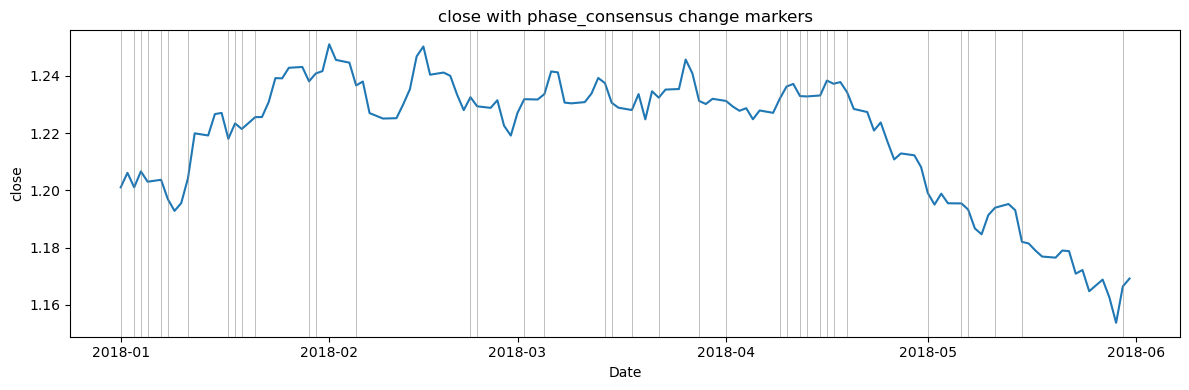

In [38]:
viz.plot_phase_timeline(
    base,
    date_col="date",
    close_col="close",
    phase_col="phase_consensus",
    start="2018-01-01",
    end="2018-06-01"
)

**What you’ll see:**

 - Close price line
 - Vertical markers each time phase_consensus changes

## RV with volatility-regime change markers

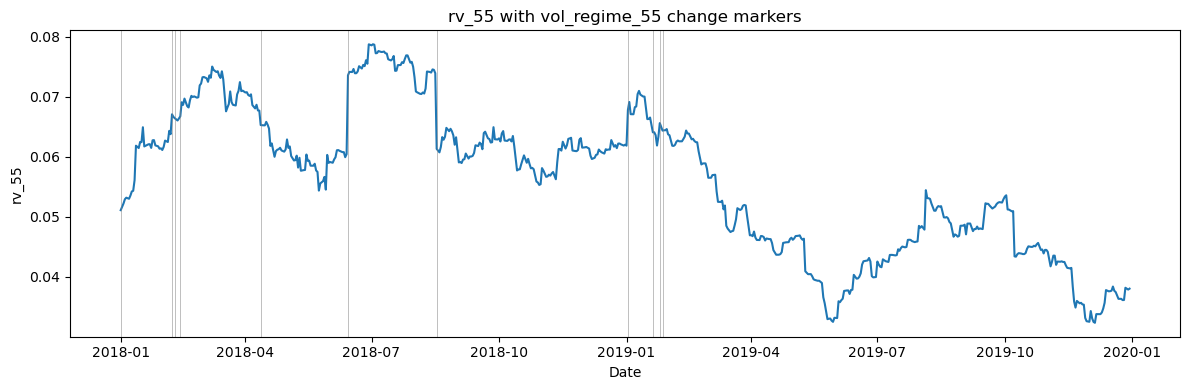

In [40]:
viz.plot_rv_with_regime(
    base,
    date_col="date",
    rv_col="rv_55",
    regime_col="vol_regime_55",
    start="2018-01-01",
    end="2019-12-31"
)

### Try different windows

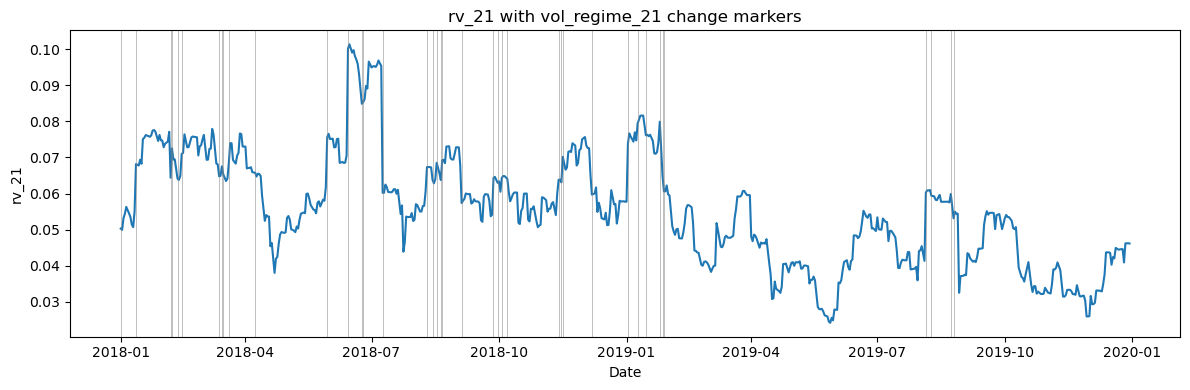

In [42]:
# 21 days
viz.plot_rv_with_regime(
    base, 
    rv_col="rv_21", 
    regime_col="vol_regime_21",
    start="2018-01-01",
    end="2019-12-31"
)

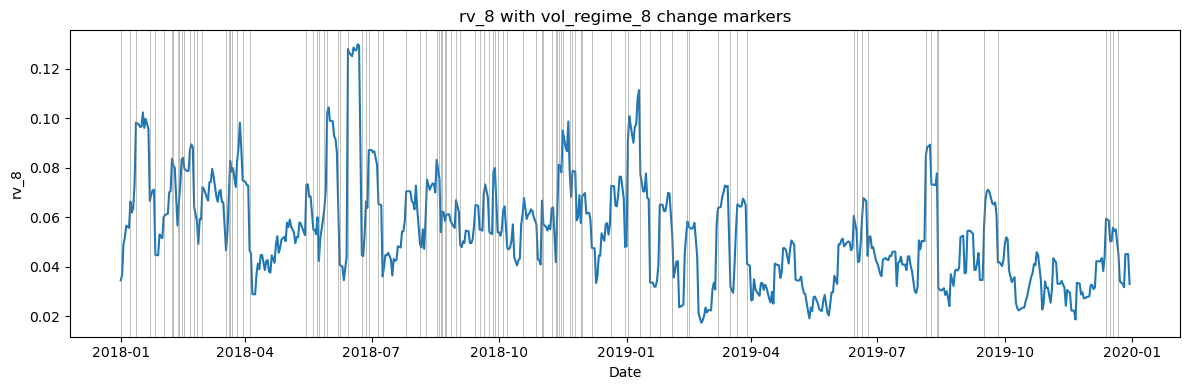

In [43]:
# 8 days
viz.plot_rv_with_regime(
    base, 
    rv_col="rv_8", 
    regime_col="vol_regime_8",
    start="2018-01-01",
    end="2019-12-31"
)

## DE distribution by phase(boxplot)

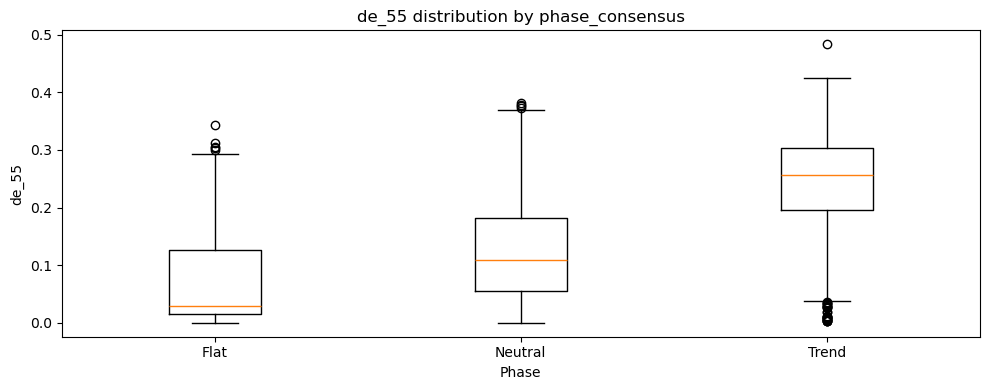

In [45]:
viz.plot_de_distribution_by_phase(
    base,
    de_col="de_55",
    phase_col="phase_consensus"
)

**This answers:**
Does DE separate Flat/Neutral/Trend in a meaningful way?

## Confusion Matrices

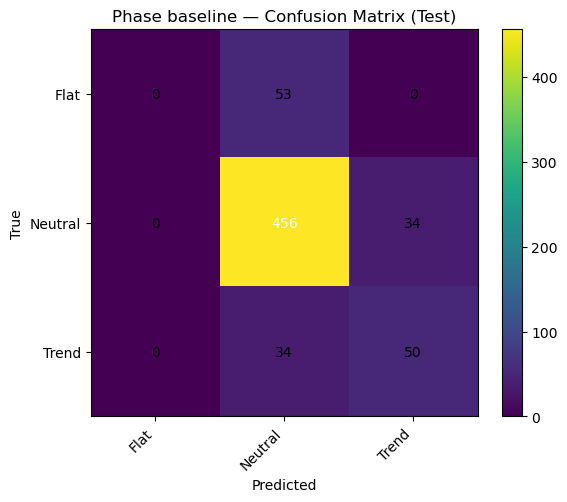

In [46]:
viz.plot_confusion_matrix(
    metrics["phase_test"]["confusion"],
    title="Phase baseline — Confusion Matrix (Test)"
)

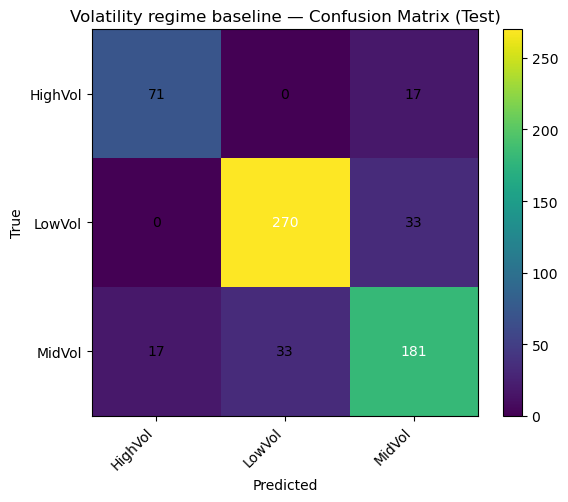

In [47]:
viz.plot_confusion_matrix(
    metrics["vol_test"]["confusion"],
    title="Volatility regime baseline — Confusion Matrix (Test)"
)


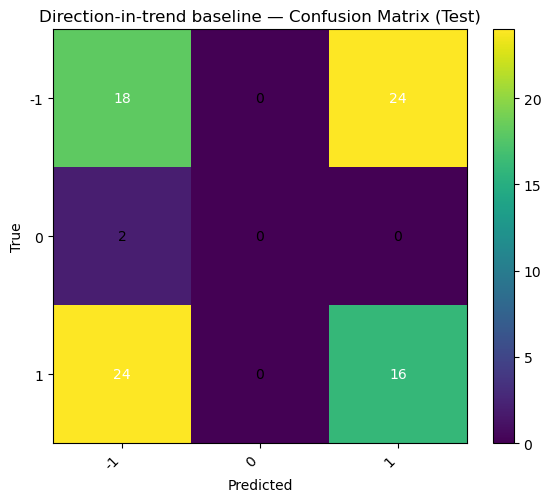

In [48]:
viz.plot_confusion_matrix(
    metrics["direction_in_trend_test"]["confusion"],
    title="Direction-in-trend baseline — Confusion Matrix (Test)"
)


## Quick dashboard cell

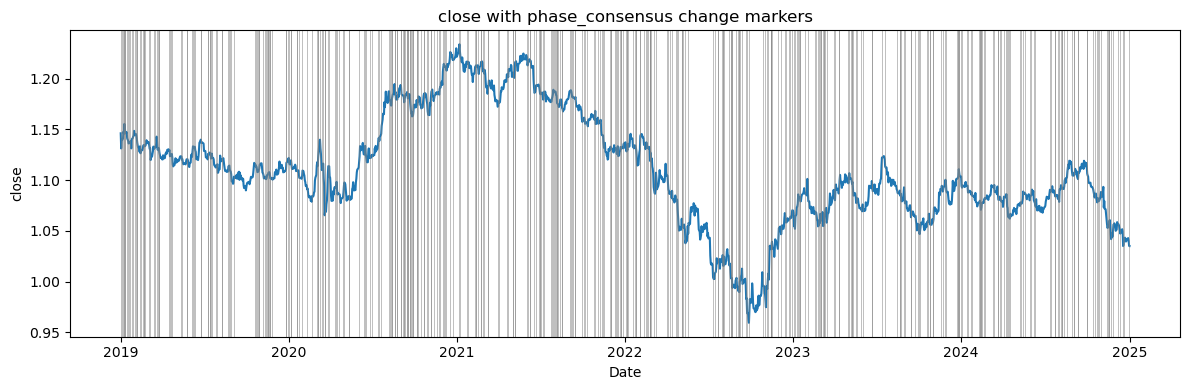

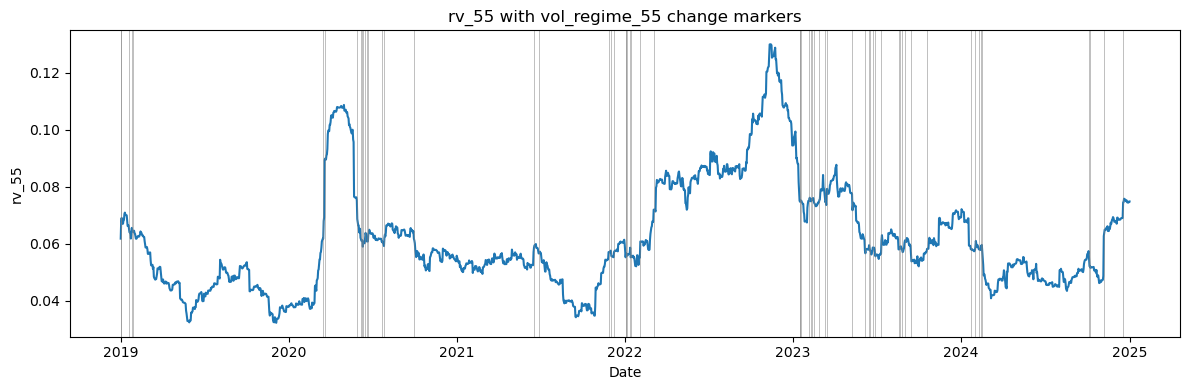

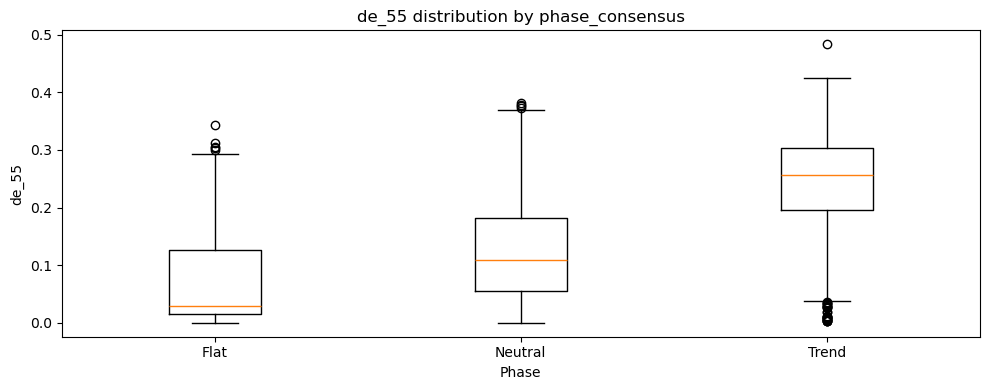

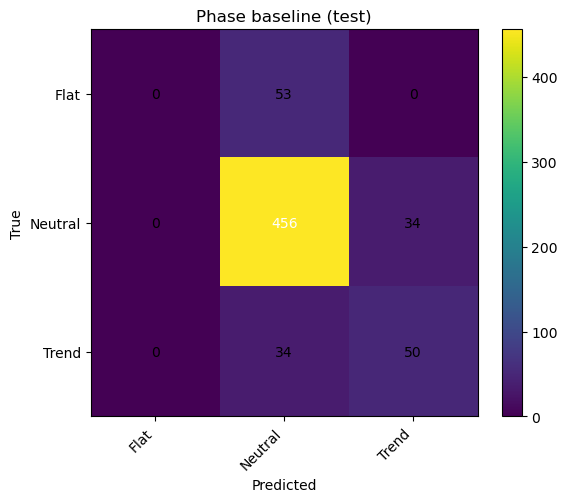

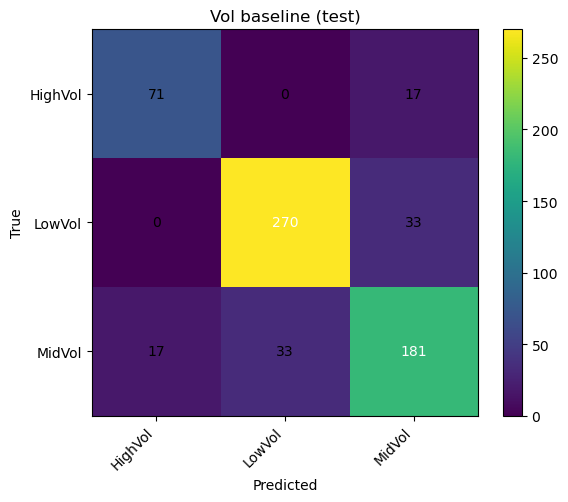

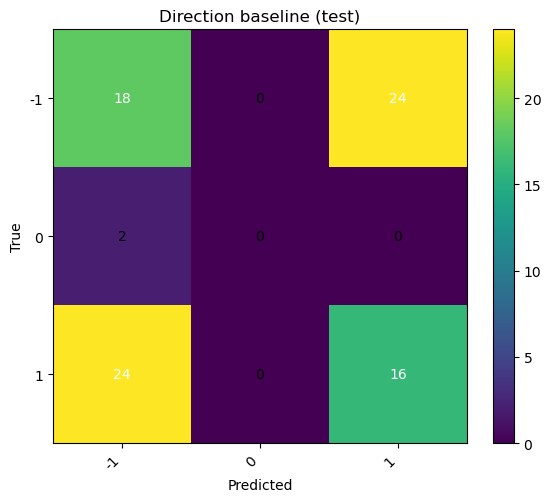

In [49]:
# Quick dashboard-like run
viz.plot_phase_timeline(base, start="2019-01-01")
viz.plot_rv_with_regime(base, rv_col="rv_55", regime_col="vol_regime_55", start="2019-01-01")
viz.plot_de_distribution_by_phase(base, de_col="de_55", phase_col="phase_consensus")

viz.plot_confusion_matrix(metrics["phase_test"]["confusion"], "Phase baseline (test)")
viz.plot_confusion_matrix(metrics["vol_test"]["confusion"], "Vol baseline (test)")
viz.plot_confusion_matrix(metrics["direction_in_trend_test"]["confusion"], "Direction baseline (test)")


# 🧠 Research Summary — Logic-First Baselines

## Goal

Validate whether **deterministic market structure rules (no ML, no look-ahead)** already provide predictive value for:

1. Market **phases** (Trend / Neutral / Flat)  
2. **Volatility regimes**  
3. **Directional moves inside trends**

---

## 1) Phase Prediction — Markov Argmax Baseline

**Results**
- Raw accuracy: **80.7%**
- Balanced accuracy: **50.9%**
- Model predicts mostly **Neutral**, rarely Flat.

**Interpretation**

- The high raw accuracy is largely due to **class imbalance**.  
- Behavior ≈  
  > “If in doubt → stay in Neutral.”

**Implications**

- Phase structure exists but current labeling does **not create strongly separable predictive states**.  
- Phase model is useful mainly as a **context filter**, not a trading signal.

---

## 2) Volatility Regimes — Persistence Baseline

**Results**
- Regime accuracy: **83.9%**
- Balanced accuracy: **82.7%**
- RV MAE: **0.0025**  
- RV RMSE: **0.0037**

**Interpretation**

- Volatility shows **strong and stable persistence**.  
- Most errors are **adjacent transitions** (High ↔ Mid, Low ↔ Mid) → regimes are economically coherent.

**Implications**

- This is a **hard benchmark** for any ML model.  
- Any advanced model must beat:

> 🎯 ~0.83 balanced accuracy  
> 🎯 persistence MAE/RMSE

**Core confirmation**

> ✅ *Volatility regime is the most reliable non-ML signal.*

---

## 3) Direction Inside Trend — EMA Baseline

**Results**
- Coverage: **13%** of days  
- Accuracy: **40%**  
- Balanced accuracy: **27%**

**Interpretation**

- EMA sign is **not aligned with next-day returns**.  
- Trend gating does **not isolate true momentum**.

**Implications**

- Direction must be redesigned:
  - longer horizons (3–5 days),
  - alternative targets,
  - regime-conditional logic.

---

# 🎯 Final Conclusions

### What Works

- ✅ Volatility regimes are **highly persistent and predictive**  
- ✅ Non-ML baselines already provide strong risk context  
- ✅ Market structure can be extracted without neural nets

### What Doesn’t (yet)

- ❌ Phase labeling needs redesign  
- ❌ Directional proxy is inadequate

---

## Strategic Outcome

1. **Volatility-first architecture is validated**  
2. ML should focus on:
   - better phase separation,  
   - multi-day directional targets,  
   - regime-aware models.

---

## One-Sentence Takeaway

> **Risk regime structure is real and exploitable without ML;  
> directional alpha requires context-aware modeling.**
